In [36]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit import Aer, execute
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
#backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.visualization import array_to_latex
basis_gates=['cx', 'id', 'rz', 'x', 'sx']
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def Shat(A,T,G): 
    
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    Shatf = np.array([[1-t*tt,0,0,t+tt],[0,1+t*tt,t-tt,0],[0,-t+tt,1+t*tt,0],[-t-tt,0,0,1-t*tt]],dtype=complex)
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    #Shat = (-1/np.sqrt(Nalpha))*Shat
    return Shat

def Nk(T):
    return (np.cosh(T/2))/2

def K(T):
    
    K2 = Ur = np.zeros((2,2), dtype=complex)
    
    coef1 = np.cos(np.pi/4 + 1j*T/2)
    coef2 = np.cos(np.pi/4 - 1j*T/2)
    
    K2[0,0]=coef1
    K2[1,1]=coef2
    #K2 = 1/np.sqrt(np.cosh(T)/2)*K2
    
    return K2

def Na(A,T,G):
    return 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)




In [14]:
np.allclose(matrix@matrix.conj().T,np.eye(8))

True

In [5]:
import os 
from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

In [6]:
#only if not saved already
from quantuminspire.credentials import save_account
save_account('1549f0e9cf336b539c2fea0d4f0869ce002d9900') #if token changes change it here too

In [7]:
#we connect to QI, our account is saved in disk, if not just run cell above
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)

In [8]:
QI.backends()

[<QuantumInspireBackend('Spin-2')>,
 <QuantumInspireBackend('Starmon-5')>,
 <QuantumInspireBackend('QX-34-L')>,
 <QuantumInspireBackend('QX single-node simulator')>]

In [10]:
Had = 1/(np.sqrt(2))*np.array([[1,0,0,1],[0,1,1,0],[0,1,-1,0],[1,0,0,-1]], dtype=complex)

In [11]:
A,G,T=10.118,0,6.0
#layer by layer unitarity check 
layer1 = np.kron(Shat(A,T,G),K(T/2))
layer1tilde=np.kron(Had,K(T/2))
layer2 = np.kron(K(-T/2),Shat(A,T,0))
layer2tilde = np.kron(K(-T/2),Had)
layer3 = np.kron(Shat(A,T,-G),K(T/2))
print(np.allclose(layer1@layer1.conj().T,np.eye(8)),np.allclose(layer2@layer2.conj().T,np.eye(8)),np.allclose(layer3@layer3.conj().T,np.eye(8)))
layer4 = np.kron(K(-T/2),Shat(A,T,-G))
layer5 = np.kron(Shat(A,T,0),K(T/2))
layer6 = np.kron(K(-T/2),Shat(A,T,G))
print(np.allclose(layer4@layer4.conj().T,np.eye(8)),np.allclose(layer5@layer5.conj().T,np.eye(8)),np.allclose(layer6@layer6.conj().T,np.eye(8)))

False False False
False False False


In [15]:
x=np.exp(T/4);y=np.exp(G/4)
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
Q1plus=np.kron(X,np.eye(4))
Q2plus=np.kron(Z,np.kron(X,np.eye(2)))
Q3plus=np.kron(Z,np.kron(Z,X))
Q1min=np.kron(Y,np.eye(4))
Q2min=np.kron(Z,np.kron(Y,np.eye(2)))
Q3min=np.kron(Z,np.kron(Z,Y))
Qtotbefore1=Q1plus*(x*y)+Q2plus*(1/(x*y))+Q3plus*(x*y) + Q1min*(y/x)+Q2min*(x/y)+Q3min*(y/x)

In [16]:
matrix=layer6@layer5@layer4@layer3@layer2@layer1*(1/(Na(A,T,G)*(Na(A,T,0)*(Na(A,T,-G)*Nk(T)**(3)))))
#matrix=layer2@layer1*(1/((Na(A,T,0)*Nk(T))))
matrixtilde=layer2tilde@layer1tilde

In [17]:
coef=(matrixtilde@matrixtilde.conj().T)[1,1]
print(coef)

(25.339454515306972-2.5026866669207594e-17j)


/home/alberto/anaconda3/envs/qusim/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


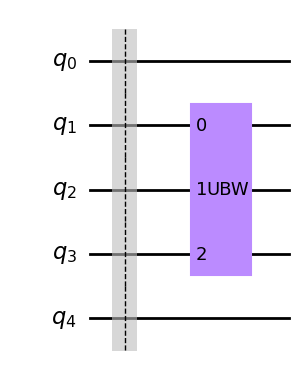

In [18]:
n=5

qc = QuantumCircuit(n)
###

###
l=0
layer=1
while l<layer:
    ##1
    qc.barrier(range(n))
    #qc.unitary((1/np.sqrt(coef))*matrixtilde,[0,1,2],label='ff')
    qc.unitary(matrix,[1,2,3],label='UBW')
    #qc.unitary(Shat(A,T,G),[0,1],label='S12 +')
    #qc.unitary(K(T/2),[2],label=r'$K(\theta/2)$')  
    ##2
    #qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    #qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    ##3
    #qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
    #qc.unitary(K(T/2),[2],label=r'$K(\theta/2)$')
    ##4
    #qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    #qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    ##5
    #qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    #qc.unitary(K(T/2),[2],label=r'$K(\theta/2)$')
    ##6
    #qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    #qc.unitary(Shat(A,T,G),[1,2],label='S23 +')
    l=+1
    


#circ = q0.compose(qc)
#circ.barrier(range(n))
op=Operator(qc)
op=op.data

#circ = circ.compose(circ.inverse())
qc.draw(output='mpl')

In [19]:
#verify fermionic symmetry for UBW or 3 sites - FERMIONIC SYMMETRY NOT SATISFIED
comm = Qtotbefore1@op-op@Qtotbefore1
print('fermionic symmetry is:',np.allclose(comm, 0*np.eye(8)))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 32 is different from 8)

In [21]:
state = Statevector.from_int(0, 2**3)
# Evolve the state by the quantum circuit
state = state.evolve(qc)
#draw using latex
state.draw('latex')

ValueError: axes don't match array

In [37]:
print(1)
print(2)

1
2


In [46]:
#check unitarity circuit
np.allclose(op@op.conj().T,np.eye(8))

True

In [47]:
#check eigenvalues for A,G,T=1,1,0.5
eigvals,_ = np.linalg.eig(op)
args = np.angle(eigvals)
print(args)

[-2.62181744  2.62181744 -0.54430885  2.62181744 -2.62181744 -0.54430885
  0.54430885  0.54430885]


In [48]:
#first we do it with Aer so that we can use Statevector class to extract final amplitudes
backend = Aer.get_backend("statevector_simulator")
result = execute(qc, backend=backend, shots=1000).result()
final=result.get_statevector()

In [49]:
#final is our post-computation statevector  
print(final[0], "=a000")
print(final[1], "=a001")
print(final[2], "=a010")
print(final[3], "=a011")
print(final[4], "=a100")
print(final[5], "=a101")
print(final[6], "=a110")
print(final[7], "=a111")

(0.49004557506474483-0.09932301568011634j) =a000
0j =a001
0j =a010
(0.04990981387102983+0.49750277424828976j) =a011
0j =a100
(0.495042500488097+0.04941591945150094j) =a101
(0.04990981387103007-0.4999902730102851j) =a110
0j =a111


In [53]:
#we compute the tangle 
a000=final[0]
a001=final[1]
a010=final[2]
a011=final[3]
a100=final[4]
a101=final[5]
a110=final[6]
a111=final[7]

d1 = a000**(2)*a111**(2)+a001**(2)*a110**(2)+a010**(2)*a101**(2)+a100**(2)*a011**(2)        
d2 = a000*a111*a011*a100 + a000*a111*a101*a010 + a000*a111*a110*a001 + a011*a100*a101*a010 + a011*a100*a110*a001 + a101*a010*a110*a001
d3 = a000*a110*a101*a011 + a111*a001*a010*a100

tau = 4*np.abs(d1-2*d2+4*d3)
print("Simulated on Qiskit - Tangle=",tau)

Simulated on Qiskit - Tangle= 0.9999505497010897


In [45]:
#then let us do the same thing with sampler and measure 
A,G,T=10.118,0,6.0
#layer by layer unitarity check 
layer1 = np.kron(Shat(A,T,G),K(T/2))
layer2 = np.kron(K(-T/2),Shat(A,T,0))

x=np.exp(T/4);y=np.exp(G/4)
Qtotbefore1=Q1plus*(x*y)+Q2plus*(1/(x*y))+Q3plus*(x*y) + Q1min*(y/x)+Q2min*(x/y)+Q3min*(y/x)
matrix=layer2@layer1*(1/((Na(A,T,0)*Nk(T))))
n=5

qc = QuantumCircuit(n,3)
###

###
l=0
layer=1
while l<layer:
    ##1
    qc.barrier(range(n))
    
    qc.unitary(matrix,[1,2,3],label='Shat')
    l=+1
    
op=Operator(qc)
op=op.data

qc.measure([1,2,3],[0,1,2]) 
qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

In [55]:
#verify fermionic symmetry for UBW or 3 sites - FERMIONIC SYMMETRY NOT SATISFIED
comm = Qtotbefore1@op-op@Qtotbefore1
print('fermionic symmetry is:',np.allclose(comm, 0*np.eye(8)))

fermionic symmetry is: True


In [47]:
shots=16384
backend = ['Starmon-5']
for back in backend:
    qi_backend = QI.get_backend(back)   #QX single-node simulator
    j=execute(qc, backend=qi_backend, shots=shots)
    result=j.result()
    counts = result.get_counts(qc)
    probs = {string:count/shots for string,count in counts.items()}
    a000 = np.sqrt(probs['000'])
    a011 = np.sqrt(probs['011'])
    a101 = np.sqrt(probs['101'])
    a110 = np.sqrt(probs['110'])
    tangle=16*a000*a011*a101*a110
    print('Simulated on '+str(qi_backend)+' - Tangle=',tangle)


KeyboardInterrupt



In [ ]:
qc.draw(output='mpl')

In [437]:
tangle=16*np.sqrt(result.quasi_dists[0][5])*np.sqrt(result.quasi_dists[0][0])*np.sqrt(result.quasi_dists[0][6])*np.sqrt(result.quasi_dists[0][3])
print(result,'    TANGLE=',tangle)

SamplerResult(quasi_dists=[{5: 0.2508125, 0: 0.25128125, 6: 0.25353125, 3: 0.244375}], metadata=[{'shots': 32000, 'circuit_metadata': {}}])     TANGLE= 0.99981293083039
